In [46]:
import matplotlib.pyplot as plt

plt.rc('font', family='serif', size=14, serif='STIXGeneral')
plt.rc('mathtext', fontset='stix')

import phoebe
import numpy as np
import pandas as pd

logger = phoebe.logger('error')

# we'll set the random seed so that the noise model is reproducible
np.random.seed(123456789)

In [58]:
#Creating fake set of observations

b = phoebe.default_binary()
b.set_value('ecc', 0.2)
b.set_value('per0', 25)
b.set_value('teff@primary', 7000)
b.set_value('teff@secondary', 6000)
b.set_value('sma@binary', 7)
b.set_value('incl@binary', 80)
b.set_value('q', 0.3)
b.set_value('t0_supconj', 0.1)
b.set_value('requiv@primary', 2.0)
b.set_value('vgamma', 80)

lctimes = phoebe.linspace(0, 10, 1005)
rvtimes = phoebe.linspace(0, 10, 105)
b.add_dataset('lc', compute_times=lctimes)
b.add_dataset('rv', compute_times=rvtimes)

b.add_compute('ellc', compute='fastcompute')
b.set_value_all('ld_mode', 'lookup')
b.run_compute(compute='fastcompute')

fluxes = b.get_value('fluxes@model') + np.random.normal(size=lctimes.shape) * 0.01
fsigmas = np.ones_like(lctimes) * 0.02

rvsA = b.get_value('rvs@primary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsB = b.get_value('rvs@secondary@model') + np.random.normal(size=rvtimes.shape) * 10
rvsigmas = np.ones_like(rvtimes) * 20

print(fluxes)

100%|██████████| 3/3 [00:00<00:00, 38.54it/s]


[1.15842339 1.14455144 1.13500698 ... 1.15930184 1.14456114 1.14422235]


In [48]:
df = pd.read_csv("./jd_target_photometry.csv")
df=df[df['julian']>2460260]
df=df[df['julian']<2460261]

In [59]:
lctimes = df['julian'].to_numpy()
fluxes = (df['refflux_5'] / df['refflux_5']).to_numpy()
#fsigmas = df["mag_err_5"].to_numpy()

fsigmas = np.ones_like(lctimes) * 0.02
print(lctimes)
print(fsigmas)

[2460260.66884259 2460260.66895833 2460260.66907407 ... 2460260.83978009
 2460260.83989583 2460260.84001157]
[0.02 0.02 0.02 ... 0.02 0.02 0.02]


In [60]:
print(max(fluxes))

1.0


In [61]:
#Create new bundle and import "fake" observations
b = phoebe.default_binary()

b.set_value('latex_repr', component='binary', value='orb')
b.set_value('latex_repr', component='primary', value='1')
b.set_value('latex_repr', component='secondary', value='2')

b.add_dataset('lc', 
              compute_phases=phoebe.linspace(0,1,201),
              times=lctimes, 
              fluxes=fluxes, 
              sigmas=fsigmas, 
              dataset='lc01')

b.add_dataset('rv', 
              compute_phases=phoebe.linspace(0,1,201),
              times=rvtimes, 
              rvs={'primary': rvsA, 'secondary': rvsB}, 
              sigmas=rvsigmas, 
              dataset='rv01')

b.set_value_all('ld_mode', 'lookup')

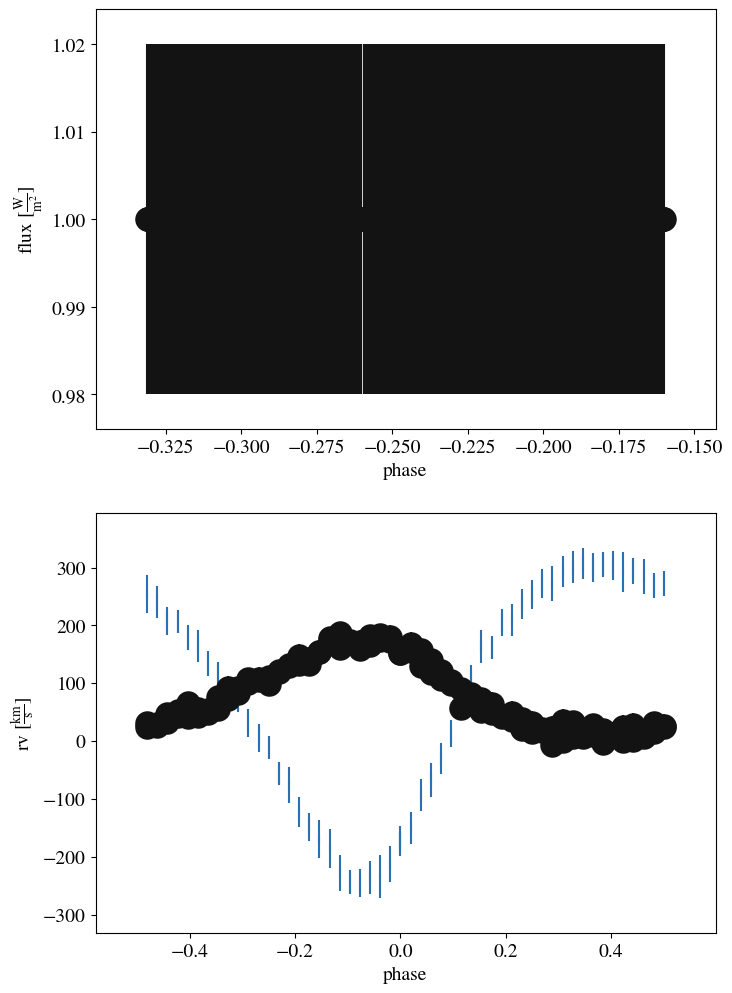

In [62]:
#Assume we know the exact orbital period
afig, mplfig = b.plot(x='phases', show=True)

In [63]:
b.add_solver('estimator.rv_geometry',
             rv_datasets='rv01',
             solver='rvgeom_solver')

<ParameterSet: 7 parameters | qualifiers: phase_bin, orbit, phase_nbins, rv_datasets, comments, expose_model, use_server>

In [64]:
b.run_solver(kind='rv_geometry', solution='rv_geom_sol')

<ParameterSet: 17 parameters | components: primary, secondary>

In [65]:
print(b.adopt_solution('rv_geom_sol', trial_run=True))

ParameterSet: 6 parameters
   t0_supconj@binary@orbit@com...: 0.12176763673771519 d
         q@binary@orbit@component: 0.30117172789490887
     asini@binary@orbit@component: 7.400351411726644 solRad
       ecc@binary@orbit@component: 0.14839619506790797
      per0@binary@orbit@component: 34.90828498370279 deg
                    vgamma@system: 80.30013525448283 km / s


In [66]:
b.add_solver('estimator.lc_geometry',
             lc_datasets='lc01',
             solver='lcgeom_solver')

<ParameterSet: 11 parameters | qualifiers: phase_bin, interactive, t0_near_times, phase_nbins, orbit, lc_combine, comments, lc_datasets, expose_model, analytical_model, use_server>

In [67]:
b.run_solver(solver='lcgeom_solver', solution='lc_geom_sol')

ValueError: attempt to get argmin of an empty sequence

In [ ]:
print(b.adopt_solution('lc_geom_sol', trial_run=True))